In [16]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Load the dataset you uploaded
base = pd.read_csv('/content/GEIH2018_filtered_data.csv')

# Display the first few rows to verify the data is loaded correctly
print(base.head())


   directorio  secuencia_p  orden  clase dominio  age  sex  estrato1  p6210  \
0     4514331            1      1      1  BOGOTA   36    1         2      5   
1     4514333            1      1      1  BOGOTA   51    1         2      6   
2     4514334            1      1      1  BOGOTA   45    1         2      3   
3     4514335            1      1      1  BOGOTA   61    1         2      3   
4     4514339            1      1      1  BOGOTA   35    0         2      5   

   p6240  ...  maxEducLevel  totalHoursWorked  formal  informal  cuentaPropia  \
0      1  ...           6.0                45       1         0             0   
1      1  ...           7.0                48       1         0             0   
2      1  ...           4.0                56       1         0             0   
3      1  ...           3.0                40       0         1             0   
4      1  ...           6.0                40       1         0             0   

   microEmpresa  sizeFirm    y_total_m

In [18]:
# Create the 'Log_salario' variable
base['Log_salario'] = np.log(base['y_total_m_ha'])

# Drop variables with high collinearity
base_reducida = base.drop(columns=['y_total_m_ha', 'y_total_m', 'Log_salario', 'dominio','orden','secuencia_p','directorio','clase','p6240','p7040','depto','mes'])

# Define categorical variables for dummy creation
categorical_vars = ['estrato1', 'p6210', 'relab', 'sizeFirm']

# Create dummies for categorical variables, dropping the first level
base_dummies = pd.get_dummies(base_reducida, columns=categorical_vars, drop_first=True)


In [19]:
# Define numerical variables
numericas = ['age', 'p6426', 'p6870', 'p7070', 'maxEducLevel', 'totalHoursWorked']

# Create squared versions of numerical variables
for i in numericas:
    base_dummies[f'{i}^2'] = base_reducida[i] ** 2

# Add the 'Log_salario' back into the dummy dataframe
base_dummies['Log_salario'] = base['Log_salario']


In [20]:
# Define dependent and independent variables
X = base_dummies.drop(columns=['Log_salario'])
y = base_dummies['Log_salario']

# Split the data into training and testing sets
seed = 202013547
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

# Convert all boolean columns to integers
X_train = X_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
X_test = X_test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


In [22]:
# Step 5: Correct Missing or Infinite Values in X_train and y_train
# Replace inf values with NaN to handle them the same way
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values in either X_train or y_train
X_train_cleaned = X_train.dropna()
y_train_cleaned = y_train[X_train_cleaned.index]

# Backward elimination function
def backward_elimination(X, y, significance_level=0.05):
    features = list(X.columns)
    while len(features) > 0:
        X_with_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_with_const).fit()
        pvalues = model.pvalues.iloc[1:]  # Exclude constant
        max_pval = pvalues.max()
        if max_pval > significance_level:
            excluded_feature = pvalues.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features

# Apply Backward Elimination after cleaning the dataset
selected_features_backward = backward_elimination(X_train_cleaned, y_train_cleaned)
print("Selected features by Backward Elimination:", selected_features_backward)


Selected features by Backward Elimination: ['age', 'sex', 'p6426', 'p6870', 'p7070', 'maxEducLevel', 'totalHoursWorked', 'formal', 'informal', 'cuentaPropia', 'microEmpresa', 'estrato1_3', 'estrato1_4', 'estrato1_5', 'estrato1_6', 'p6210_3', 'p6210_4', 'p6210_6', 'relab_2', 'relab_4', 'relab_5', 'sizeFirm_3', 'sizeFirm_4', 'sizeFirm_5', 'age^2', 'p6426^2', 'p6870^2', 'p7070^2', 'maxEducLevel^2', 'totalHoursWorked^2']


In [24]:
# Step 6: Fit final model with selected features from backward elimination

# Select the features that survived backward elimination in the cleaned dataset
X_train_selected = X_train_cleaned[selected_features_backward]

# Add a constant to the selected features
X_train_selected_const = sm.add_constant(X_train_selected)

# Fit the final OLS model using the selected features
final_model = sm.OLS(y_train_cleaned, X_train_selected_const).fit()

# Print the model summary
print(final_model.summary())


                            OLS Regression Results                            
Dep. Variable:            Log_salario   R-squared:                       0.584
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     482.8
Date:                Mon, 16 Sep 2024   Prob (F-statistic):               0.00
Time:                        01:40:05   Log-Likelihood:                -6753.0
No. Observations:                8963   AIC:                         1.356e+04
Df Residuals:                    8936   BIC:                         1.375e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.7531      0

In [25]:
# Step 7: Evaluate model performance on test set

# Apply the same cleaning process to the test set
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_cleaned = X_test.dropna()

# Make sure the test set has the same features as the training set
X_test_selected = X_test_cleaned[selected_features_backward]

# Add a constant to the test set
X_test_selected_const = sm.add_constant(X_test_selected)

# Make predictions on the test set
y_pred = final_model.predict(X_test_selected_const)

# Ensure y_test has no missing values corresponding to the cleaned test set
y_test_cleaned = y_test[X_test_cleaned.index]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_cleaned, y_pred))

# Print the RMSE
print(f"RMSE on the test set: {rmse:.4f}")


RMSE on the test set: 0.5352


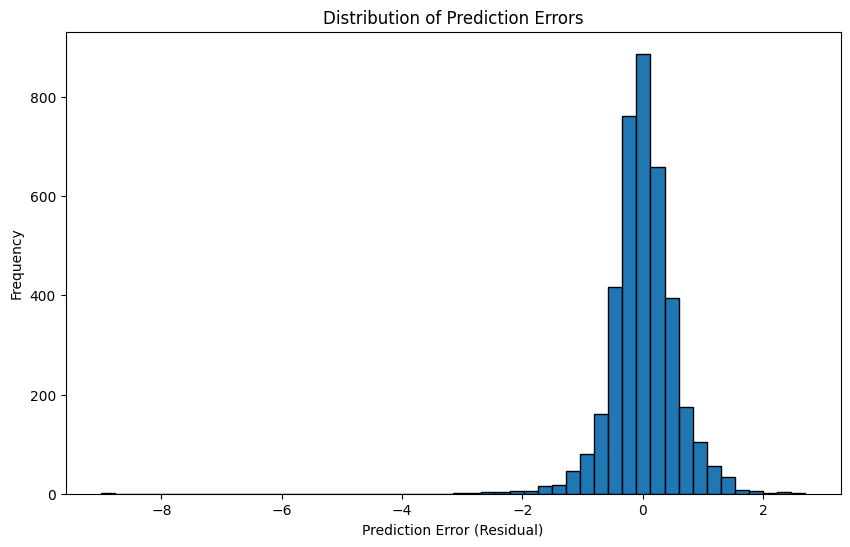

1st and 99th percentile of errors: -1.4415164596297991 1.3686947867808017
5th and 95th percentile of errors: -0.7681723231253027 0.871227433262387
Number of high outliers (> 99th percentile): 39
Number of low outliers (< 1st percentile): 39
Examples of high outliers (positive errors):
2871     1.912892
11876    1.978198
9830     1.449093
9179     2.282975
831      1.383450
dtype: float64
Examples of low outliers (negative errors):
1982    -1.516573
6757    -1.627233
1332    -3.043016
2004    -1.560355
12288   -2.344285
dtype: float64


In [26]:
import matplotlib.pyplot as plt

# Step 8: Compute prediction errors (residuals)
errors = y_test_cleaned - y_pred

# Analyze the distribution of the errors
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.show()

# Check for outliers: examine the tails of the error distribution
error_quantiles = np.percentile(errors, [1, 5, 95, 99])
print("1st and 99th percentile of errors:", error_quantiles[0], error_quantiles[3])
print("5th and 95th percentile of errors:", error_quantiles[1], error_quantiles[2])

# Identify potential outliers in the tails (top/bottom 1% of errors)
outliers_high = errors[errors > error_quantiles[3]]
outliers_low = errors[errors < error_quantiles[0]]

print(f"Number of high outliers (> 99th percentile): {len(outliers_high)}")
print(f"Number of low outliers (< 1st percentile): {len(outliers_low)}")

# Show some examples of the largest errors (optional)
print("Examples of high outliers (positive errors):")
print(outliers_high.head())
print("Examples of low outliers (negative errors):")
print(outliers_low.head())
